In [1]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.base import clone
from rfpimp import *
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rf_model = pickle.load(open('random_forest_completion_first_quarter.p', 'rb')) # load the model

In [3]:
# model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=20, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)

In [4]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='red')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [5]:
# X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
# y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
# y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')

y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
# X_train.fillna(value = 0, inplace = True)
# X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)

In [6]:
    predictions = rf_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions)
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

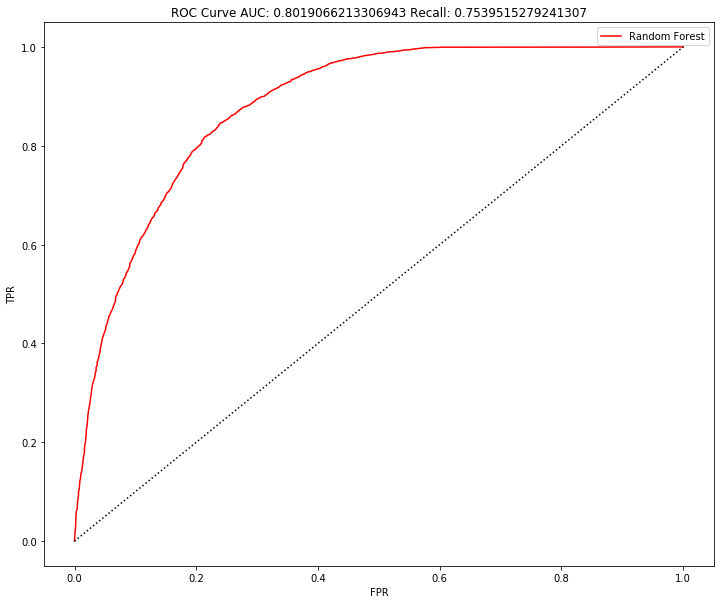

Best Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Roc Auc: 0.8019066213306943

Recall Score: 0.7539515279241307

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.85      0.80      5062
        True       0.85      0.75      0.80      5694

   micro avg       0.80      0.80      0.80     10756
   macro avg       0.80      0.80      0.80     10756
weighted avg       0.80      0.80      0.80     10756


Confusion Matrix:
 [[4293  760]
 [1401 4302]]


In [7]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(rf_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

In [9]:
feat_imp = importances(rf_model, X_test, y_test)

In [10]:
feat_imp.sort_values(by='Importance', ascending=False)[0:10]

,Importance
Feature,
avg_score,0.0732
code_module_GGG,0.0120
sum_days_vle_accessed,0.0108
sum_click_quiz,0.0062
score_first_assessment,0.0052
code_presentation_2014B,0.0046
days_early_first_assessment,0.0042
sum_click_page,0.0036
sum_click_url,0.0036


In [11]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[300:1000:25]

,fprs,tprs,Thresholds
300,0.121531,0.640656,0.658
325,0.142606,0.685500,0.631
350,0.160520,0.720269,0.606
375,0.178433,0.760964,0.580
400,0.199157,0.792967,0.554
425,0.219705,0.822205,0.529
450,0.240955,0.846503,0.504
475,0.266070,0.867049,0.478
500,0.291711,0.886606,0.451
525,0.314190,0.902608,0.424
